In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions as fn
from sklearn.linear_model import LinearRegression

In [8]:
sqlQuery = '''
SELECT 
DISTINCT gl.gameID,
gl.goalDate as gameDate,
gl.teamID,
count(gl.teamID) as goals,
ga.winner 
from nhl.dbo.goals gl
join nhl.dbo.game ga on gl.gameID = ga.gameID  
GROUP by gl.gameID, gl.teamID, gl.goalDate, ga.winner 
ORDER BY gl.goalDate, gl.gameID, gl.teamID 
'''

In [9]:
df = pd.read_sql_query(sqlQuery, fn.dbConnection())
df = df.rename(columns={'gameid':'gameID','gamedate':'gameDate','teamid':'teamID'})

In [10]:
df['gameDate'] = pd.to_datetime(df['gameDate'], format='%Y-%m-%d')
df = df.set_index('gameID')
df

,gameDate,teamID,goals,winner
gameID,,,,
20231010CHI@PIT,2023-10-10,CHI,4,CHI
20231010CHI@PIT,2023-10-10,PIT,2,CHI
20231010NSH@TB,2023-10-10,NSH,3,TB
20231010NSH@TB,2023-10-10,TB,5,TB
20231011CHI@BOS,2023-10-11,BOS,3,BOS
...,...,...,...,...
20231112DAL@MIN,2023-11-12,MIN,3,DAL
20231112SJ@ANA,2023-11-12,ANA,4,ANA
20231112SJ@ANA,2023-11-12,SJ,1,ANA


In [11]:
def winner(x):
    if x[0] == x[1]: return 'winner'
    else: return 'loss'

In [12]:
df['win'] = df[['teamID','winner']].apply(winner, axis=1)

/var/folders/w8/tgwf_kks31b4n340v9tt6m6r0000gn/T/ipykernel_50863/1930560119.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[0] == x[1]: return 'winner'


In [13]:
df = df.drop('winner', axis=1)

In [14]:
avgWin = df.loc[df['win'] == 'winner']['goals'].mean()
avgLoss = df.loc[df['win'] == 'loss']['goals'].mean()

In [15]:
x = df.loc[df['win'] == 'winner']['goals'].unique()
y = df.loc[df['win'] == 'winner']['goals'].value_counts()
y = np.array(y)

wdf = pd.DataFrame({'numberOfGoals':x, 'wins':y})
wdf = wdf.set_index('numberOfGoals')




x1 = df.loc[df['win'] == 'loss']['goals'].unique()
y1 = df.loc[df['win'] == 'loss']['goals'].value_counts()

ldf = pd.DataFrame({'numberOfGoals':x1, 'losses':y1})
ldf = ldf.set_index('numberOfGoals')

gdf = pd.merge(wdf, ldf, how='outer', on='numberOfGoals' )


In [16]:
gdf = gdf.replace(np.nan,0)
gdf.losses = gdf.losses.astype(int)
gdf = gdf.sort_index()
gdf

,wins,losses
numberOfGoals,,
1,2,46
2,8,70
3,46,53
4,67,1
5,50,21
6,14,0
7,5,5
8,27,0
10,1,0


In [17]:
x = gdf.index
yw =  gdf['wins']
yl = gdf['losses']

In [18]:
polyDegrees = 3

In [19]:
zw = np.polyfit(x, yw, polyDegrees)
fw = np.poly1d(zw)
xw_n = np.linspace(x[0], x[-1], 50)
yw_n = fw(xw_n)

In [20]:
zl = np.polyfit(x, yl, polyDegrees)
fl = np.poly1d(zl)
xl_n = np.linspace(x[0], x[-1], 50)
yl_n = fl(xl_n)

In [21]:
x3 = str(float("{:.2f}".format(fl[3]))) + 'x' + '\N{SUPERSCRIPT THREE}'
x2 = str(float("{:.2f}".format(fl[2]))) + 'x' +'\N{SUPERSCRIPT TWO}'
x1 = str(float("{:.2f}".format(fl[1]))) + 'x'
x0 = str(float("{:.2f}".format(fl[0])))
if fl[2]>0: x2= '+ '+x2
if fl[1]>0: x1= '+ '+x1
if fl[0]>0: x0= '+ '+x0
else: x0 = '- '+x0
fl_equ = f'{x3} {x2} {x1} {x0}'

x3 = str(float("{:.2f}".format(fw[3]))) + 'x' + '\N{SUPERSCRIPT THREE}'
x2 = str(float("{:.2f}".format(fw[2]))) + 'x' +'\N{SUPERSCRIPT TWO}'
x1 = str(float("{:.2f}".format(fw[1]))) + 'x'
x0 = str(float("{:.2f}".format(fl[0])))
if fw[2]>0: x2= '+ '+x2
if fw[1]>0: x1= '+ '+x1
if fw[0]>0: x0= '+ '+x0 
else: x0 = '- '+x0
fw_equ = f'{x3} {x2} {x1} {x0}'
fw_equ


'0.6x³ -11.75x² + 64.24x - 62.24'

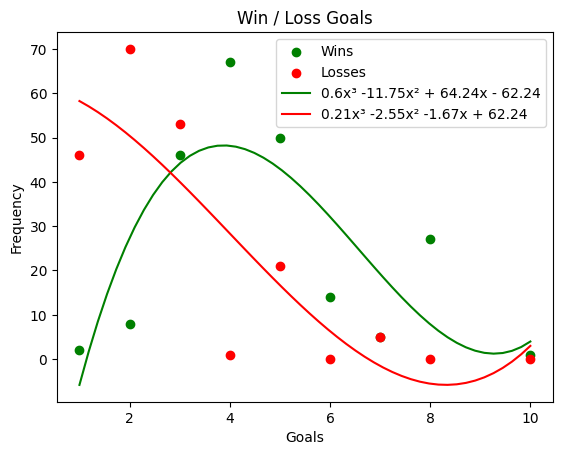

In [22]:
plt.scatter(x, yw, color = 'green', label = 'Wins')
plt.scatter(x, yl, color = 'red', label = 'Losses')
plt.plot(xw_n, yw_n, color = 'green', label = fw_equ)
plt.plot(xl_n, yl_n, color = 'red', label = fl_equ)
plt.title('Win / Loss Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [23]:
def lossPercentage(x):
    wins = x[0]
    loss = x[1]
    total = wins + loss
    percent = (float("{:.2f}".format(loss * (100/total))))
    return percent
def winPercentage(x):
    wins = x[0]
    loss = x[1]
    total = wins + loss
    percent = (float("{:.2f}".format(wins * (100/total))))
    return percent
    
gdf['win%'] = gdf[['wins','losses']].apply(winPercentage, axis=1)
gdf['loss%'] = gdf[['wins','losses']].apply(lossPercentage, axis=1)
gdf

/var/folders/w8/tgwf_kks31b4n340v9tt6m6r0000gn/T/ipykernel_50863/3712979072.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wins = x[0]
/var/folders/w8/tgwf_kks31b4n340v9tt6m6r0000gn/T/ipykernel_50863/3712979072.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loss = x[1]
/var/folders/w8/tgwf_kks31b4n340v9tt6m6r0000gn/T/ipykernel_50863/3712979072.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wins = x[0]
/var/folders/w8/

,wins,losses,win%,loss%
numberOfGoals,,,,
1,2,46,4.17,95.83
2,8,70,10.26,89.74
3,46,53,46.46,53.54
4,67,1,98.53,1.47
5,50,21,70.42,29.58
6,14,0,100.00,0.00
7,5,5,50.00,50.00
8,27,0,100.00,0.00
10,1,0,100.00,0.00


In [24]:
polyDegrees = 3


xp = gdf.index
ywp =  gdf['win%']
ylp = gdf['loss%']

zwp = np.polyfit(xp, ywp, polyDegrees)
fwp = np.poly1d(zwp)
xwp_n = np.linspace(xp[0], xp[-1], 50)
ywp_n = fwp(xwp_n)

zlp = np.polyfit(xp, ylp, polyDegrees)
flp = np.poly1d(zlp)
xlp_n = np.linspace(xp[0], xp[-1], 50)
ylp_n = flp(xlp_n)


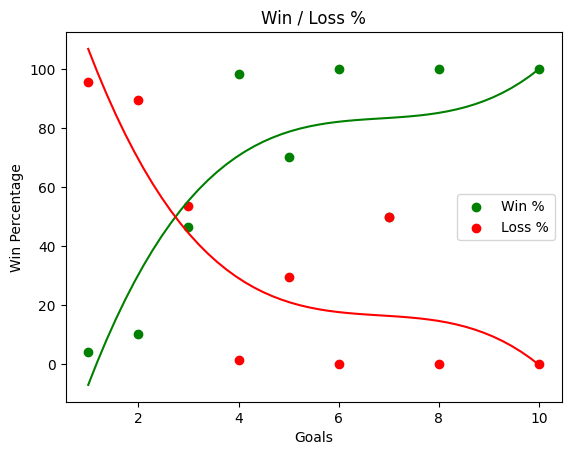

In [25]:
plt.scatter(xp, ywp, color = 'green', label = 'Win %')
plt.scatter(xp, ylp, color = 'red', label = 'Loss %')
plt.plot(xwp_n, ywp_n, color = 'green')
plt.plot(xlp_n, ylp_n, color = 'red')
plt.title('Win / Loss %')
plt.xlabel("Goals")
plt.ylabel('Win Percentage')
plt.legend()
plt.show()

In [26]:
print('Losses over 3 goals scored')
losses = (df.loc[(df['goals'] > 3)])
losses = (losses.loc[losses['win'] == 'loss'])
losses = losses['goals'].value_counts()
print(losses)

Losses over 3 goals scored
goals
4    21
5     5
7     1
Name: count, dtype: int64
